In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score

In [2]:
airline = pd.read_csv("data/train_airline.csv")

In [3]:
def standard_column_names(dataframe):
    return dataframe.columns.str.replace(" ", "_").str.lower()

In [4]:
airline.columns = standard_column_names(airline)

In [5]:
def standard_features_string(dataframe):
    for column in dataframe.columns:
        if dataframe[column].dtype == "object":
            dataframe[column] = dataframe[column].str.replace(" ", "_").str.lower()
        else:
            pass
    return dataframe

In [6]:
airline = standard_features_string(airline)

In [7]:
airline.head()

,id,gender,customer_type,age,type_of_travel,class,flight_distance,inflight_wifi_service,departure/arrival_time_convenient,ease_of_online_booking,...,inflight_entertainment,on-board_service,leg_room_service,baggage_handling,checkin_service,inflight_service,cleanliness,departure_delay_in_minutes,arrival_delay_in_minutes,satisfaction
0,70172,male,loyal_customer,13,personal_travel,eco_plus,460,3,4,3,...,5,4,3,4,4,5,5,25,18.0,neutral_or_dissatisfied
1,5047,male,disloyal_customer,25,business_travel,business,235,3,2,3,...,1,1,5,3,1,4,1,1,6.0,neutral_or_dissatisfied
2,110028,female,loyal_customer,26,business_travel,business,1142,2,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,24026,female,loyal_customer,25,business_travel,business,562,2,5,5,...,2,2,5,3,1,4,2,11,9.0,neutral_or_dissatisfied
4,119299,male,loyal_customer,61,business_travel,business,214,3,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


In [8]:
airline.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 24 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   id                                 103904 non-null  int64  
 1   gender                             103904 non-null  object 
 2   customer_type                      103904 non-null  object 
 3   age                                103904 non-null  int64  
 4   type_of_travel                     103904 non-null  object 
 5   class                              103904 non-null  object 
 6   flight_distance                    103904 non-null  int64  
 7   inflight_wifi_service              103904 non-null  int64  
 8   departure/arrival_time_convenient  103904 non-null  int64  
 9   ease_of_online_booking             103904 non-null  int64  
 10  gate_location                      103904 non-null  int64  
 11  food_and_drink                     1039

In [9]:
airline["total_delay"] = airline["arrival_delay_in_minutes"] + airline["departure_delay_in_minutes"]
airline = airline.drop(["arrival_delay_in_minutes", "departure_delay_in_minutes"], axis=1)

In [10]:
airline["satisfaction"] = airline["satisfaction"].map({"neutral_or_dissatisfied": 0, "satisfied": 1})
airline = airline.drop(["id"], axis=1)

In [11]:
X = airline.drop(["satisfaction"], axis=1)
y = airline["satisfaction"]

In [12]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                    test_size=0.2, random_state=42)

In [13]:
numerical_features = X_train.select_dtypes(include='number').columns.tolist()
categorical_features = X_train.select_dtypes(exclude='number').columns.tolist()

In [14]:
numeric_pipeline = Pipeline(steps=[
    ('Imputer', SimpleImputer(strategy='mean')),
    ('Scale', QuantileTransformer(n_quantiles=100, output_distribution="uniform"))
])

categorical_pipeline = Pipeline(steps=[
    ('Imputer', SimpleImputer(strategy= "most_frequent")),
    ('One-Hot', OneHotEncoder(handle_unknown='error', sparse=False))
])

In [15]:
full_processor = ColumnTransformer(transformers=[
    ('number', numeric_pipeline, numerical_features),
    ('category', categorical_pipeline, categorical_features),
    ])

In [16]:
X_train_transform = full_processor.fit_transform(X_train)
X_valid_transform = full_processor.transform(X_valid)
rf_clf = RandomForestClassifier(random_state=1)

In [17]:
rf_clf.fit(X_train_transform, y_train)
y_pred = rf_clf.predict(X_valid_transform)

In [18]:
rf_clf_acc_valid = accuracy_score(y_pred, y_valid)
print("Random Forest Validation Accuracy: {:.2f}%".format(rf_clf_acc_valid * 100))

Random Forest Validation Accuracy: 96.34%


In [19]:
airline_test = pd.read_csv("data/test_airline.csv")

In [20]:
airline_test.columns = standard_column_names(airline_test)

In [21]:
airline_test = standard_features_string(airline_test)

In [22]:
airline_test.head()

,id,gender,customer_type,age,type_of_travel,class,flight_distance,inflight_wifi_service,departure/arrival_time_convenient,ease_of_online_booking,...,inflight_entertainment,on-board_service,leg_room_service,baggage_handling,checkin_service,inflight_service,cleanliness,departure_delay_in_minutes,arrival_delay_in_minutes,satisfaction
0,19556,female,loyal_customer,52,business_travel,eco,160,5,4,3,...,5,5,5,5,2,5,5,50,44.0,satisfied
1,90035,female,loyal_customer,36,business_travel,business,2863,1,1,3,...,4,4,4,4,3,4,5,0,0.0,satisfied
2,12360,male,disloyal_customer,20,business_travel,eco,192,2,0,2,...,2,4,1,3,2,2,2,0,0.0,neutral_or_dissatisfied
3,77959,male,loyal_customer,44,business_travel,business,3377,0,0,0,...,1,1,1,1,3,1,4,0,6.0,satisfied
4,36875,female,loyal_customer,49,business_travel,eco,1182,2,3,4,...,2,2,2,2,4,2,4,0,20.0,satisfied


In [23]:
airline_test["total_delay"] = airline_test["arrival_delay_in_minutes"] + airline_test["departure_delay_in_minutes"]
airline_test = airline_test.drop(["arrival_delay_in_minutes", "departure_delay_in_minutes"], axis=1)

In [24]:
airline_test["satisfaction"] = airline_test["satisfaction"].map({"neutral_or_dissatisfied": 0, "satisfied":1})
airline_test = airline_test.drop(["id"], axis=1)

In [25]:
X = airline_test.drop(["satisfaction"], axis=1)
y = airline_test["satisfaction"]

In [26]:
X_test_transform = full_processor.transform(X)
y_pred_test = rf_clf.predict(X_test_transform)

In [27]:
rf_clf_acc_test = accuracy_score(y_pred_test, y)
print("Random Forest Test accuracy: {:.2f}%".format(rf_clf_acc_test * 100))

Random Forest Test accuracy: 96.32%


In [28]:
def get_feature_names_mixture_column_transformer(mixture_transformer, numerical_name, categorical_name):
    full_transformer = mixture_transformer.transformers_
    all_features = []
    for name, transformer, features in full_transformer:
        if name == numerical_name:
            all_features.append(features)
        elif name == categorical_name:
            all_features.append(transformer.named_steps["One-Hot"].get_feature_names(categorical_features).tolist())
    flat_features = [item for sublist in all_features for item in sublist]
    return flat_features

In [29]:
feature_names = get_feature_names_mixture_column_transformer(full_processor, "number", "category")
importances = rf_clf.feature_importances_

In [30]:
forest_importances = pd.Series(importances, index=feature_names)
forest_importances.sort_values(ascending=False, inplace=True)
importance_mask = np.where(forest_importances > .07, 1, 0)

In [31]:
color_important = ["lightcoral" if important == 1 else "gray" for important, value in zip(importance_mask, forest_importances)]

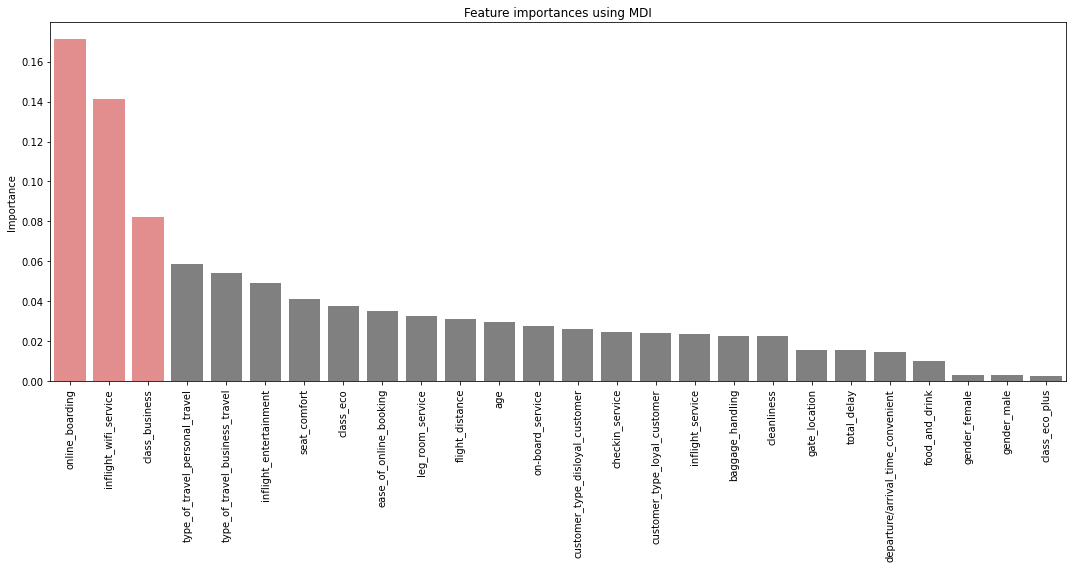

In [32]:
plt.figure(figsize=(15, 8))
sns.barplot(x=forest_importances.index, y=forest_importances.values,
            palette=color_important)
plt.title("Feature importances using MDI")
plt.ylabel("Importance")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [33]:
result = permutation_importance(
    rf_clf, X_train_transform, y_train, n_repeats=10, random_state=42)

forest_importances_permutation = pd.Series(result.importances_mean, index=feature_names)
forest_importances_permutation.sort_values(ascending=False, inplace=True)

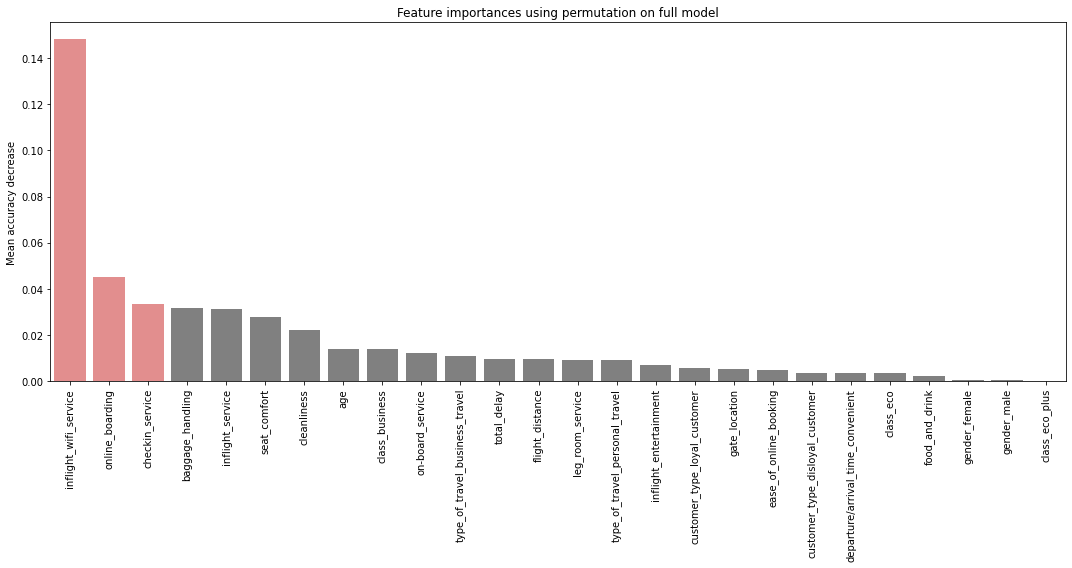

In [34]:
plt.figure(figsize=(15, 8))
sns.barplot(x=forest_importances_permutation.index, y=forest_importances_permutation.values,
            palette=color_important)
plt.title("Feature importances using permutation on full model")
plt.ylabel("Mean accuracy decrease")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Handling Multicollinear Features

When features are collinear, permutating one feature will have little effect on the models performance because it can get the same information from a correlated feature. One way to handle multicollinear features is by **performing hierarchical clustering on the Spearman rank-order correlations, picking a threshold, and keeping a single feature from each cluster.** First, we plot a heatmap of the correlated features:

In [35]:
from collections import defaultdict

from scipy.stats import spearmanr
from scipy.cluster import hierarchy

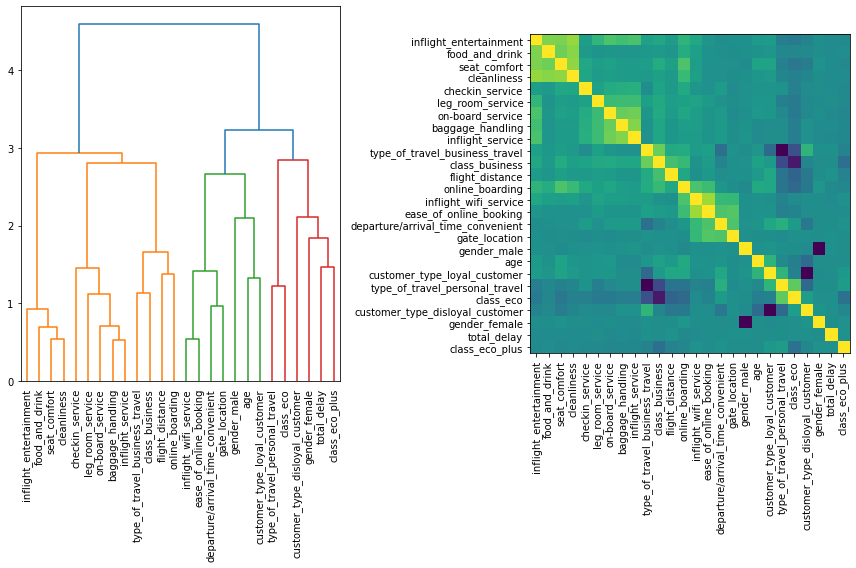

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(X_train_transform).correlation
corr_linkage = hierarchy.ward(corr)
dendro = hierarchy.dendrogram(
    corr_linkage, labels=feature_names, ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro['ivl']))

ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
ax2.set_yticklabels(dendro['ivl'])
fig.tight_layout()
plt.show()

In [37]:
cluster_ids = hierarchy.fcluster(corr_linkage, 1.5, criterion='distance')
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]

X_train_sel = X_train_transform[:, selected_features]
X_valid_sel = X_valid_transform[:, selected_features]

clf_sel = RandomForestClassifier(n_estimators=100, random_state=42)
clf_sel.fit(X_train_sel, y_train)
print("Accuracy on test data with features removed: {:.2f} %".format(
      clf_sel.score(X_valid_sel, y_valid) * 100))

Accuracy on test data with features removed: 91.95 %


In [61]:
name_of_selected_features = [feature_names[idx] for idx in selected_features]
print("Removed Features: {}".format(
    len(feature_names) - len(name_of_selected_features)))
print("Remaining Features: {}".format(
    len(name_of_selected_features)))

Removed Features: 15
Remaining Features: 11


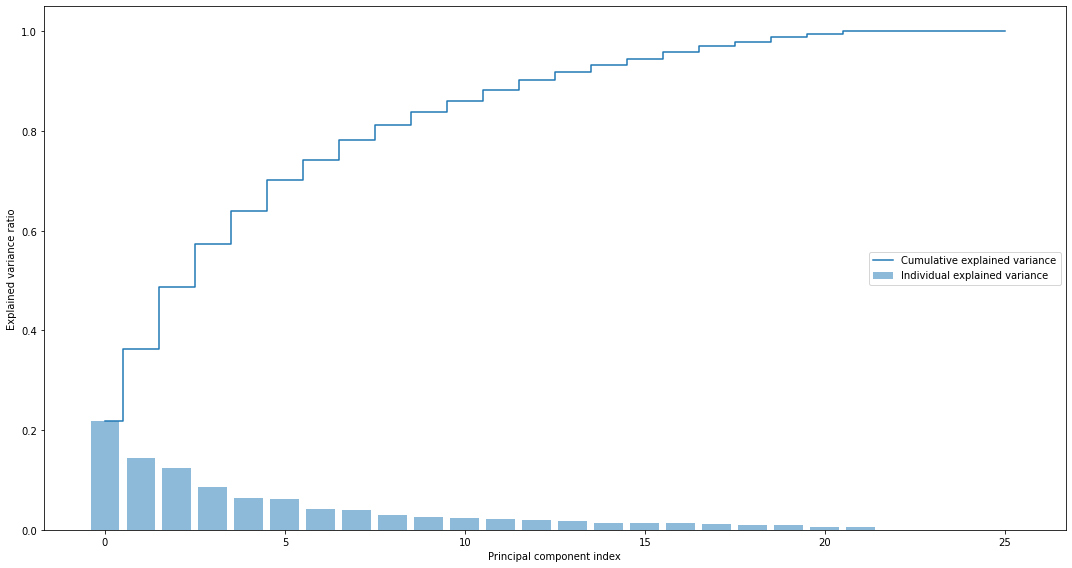

In [58]:
pca = PCA()
X_train_pca = pca.fit_transform(X_train_transform)
exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
plt.figure(figsize=(15, 8))
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='right')
plt.tight_layout()
plt.show()

In [62]:
pca = PCA(n_components=11)
X_train_pca = pca.fit_transform(X_train_transform)
X_valid_pca = pca.transform(X_valid_transform)

In [63]:
rf_clf = RandomForestClassifier(random_state=1)
rf_clf.fit(X_train_pca, y_train)
y_pred = rf_clf.predict(X_valid_pca)

In [64]:
rf_clf_pca = accuracy_score(y_pred, y_valid)
print("Random Forest with PCA Vaidation accuracy: {:.2f}%".format(rf_clf_pca * 100))

Random Forest with PCA Vaidation accuracy: 92.32%
